<a href="https://colab.research.google.com/github/jorobledo/bayesian_statistical_learning_2/blob/main/BLcourse2.3/01_one_dim_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notation
$\newcommand{\ve}[1]{\mathit{\boldsymbol{#1}}}$
$\newcommand{\ma}[1]{\mathbf{#1}}$
$\newcommand{\pred}[1]{\rm{#1}}$
$\newcommand{\predve}[1]{\mathbf{#1}}$
$\newcommand{\test}[1]{#1_*}$
$\newcommand{\testtest}[1]{#1_{**}}$
$\DeclareMathOperator{\diag}{diag}$
$\DeclareMathOperator{\cov}{cov}$

Vector $\ve a\in\mathbb R^n$ or $\mathbb R^{n\times 1}$, so "column" vector.
Matrix $\ma A\in\mathbb R^{n\times m}$. Design matrix with input vectors $\ve
x_i\in\mathbb R^D$: $\ma X = [\ldots, \ve x_i, \ldots]^\top \in\mathbb
R^{N\times D}$.

We use 1D data, so in fact $\ma X \in\mathbb R^{N\times 1}$ is a vector, but
we still denote the collection of all $\ve x_i = x_i\in\mathbb R$ points with
$\ma X$ to keep the notation consistent with the slides.

# About

In this notebook, we explore the material presented in [the
slides](https://doi.org/10.6084/m9.figshare.25988176) with code, using the
[gpytorch](https://gpytorch.ai) library. We cover exact GP inference and
hyper parameter optimization using the marginal likelihood.

# Imports, helpers, setup

In [5]:
# %matplotlib notebook
# %matplotlib widget
%matplotlib inline

In [7]:
!pip install -q gpytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 277.7/277.7 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.3/176.3 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.4/55.4 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 59.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 58.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 35.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [9]:
!wget https://raw.githubusercontent.com/jorobledo/bayesian_statistical_learning_2/refs/heads/main/BLcourse2.3/utils.py

--2025-05-22 07:41:17--  https://raw.githubusercontent.com/jorobledo/bayesian_statistical_learning_2/refs/heads/main/BLcourse2.3/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1869 (1.8K) [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]   1.83K  --.-KB/s    in 0s      

2025-05-22 07:41:17 (20.6 MB/s) - ‘utils.py’ saved [1869/1869]



In [10]:
import math
from collections import defaultdict
from pprint import pprint

import torch
import gpytorch
from matplotlib import pyplot as plt
from matplotlib import is_interactive
import numpy as np

from utils import extract_model_params, plot_samples


# Default float32 results in slightly noisy prior samples. Less so with
# float64. We get a warning with both
#   .../lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40:
#       NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
# but the noise is smaller w/ float64. Reason must be that the `sample()`
# method [1] calls `rsample()` [2] which performs a Cholesky decomposition of
# the covariance matrix. The default in
# np.random.default_rng().multivariate_normal() is method="svd", which is
# slower but seemingly a bit more stable.
#
# [1] https://docs.gpytorch.ai/en/stable/distributions.html#gpytorch.distributions.MultivariateNormal.sample
# [2] https://docs.gpytorch.ai/en/stable/distributions.html#gpytorch.distributions.MultivariateNormal.rsample
torch.set_default_dtype(torch.float64)

torch.manual_seed(123)

# Generate toy 1D data

Here we generate noisy 1D data `X_train`, `y_train` as well as an extended
x-axis `X_pred` which we use later for prediction also outside of the data
range (extrapolation). The data has a constant offset `const` which we use to
test learning a GP mean function $m(\ve x)$. We create a gap in the data to
show how the model uncertainty will behave there.

X_train.shape=torch.Size([69])
y_train.shape=torch.Size([69])
X_pred.shape=torch.Size([200])


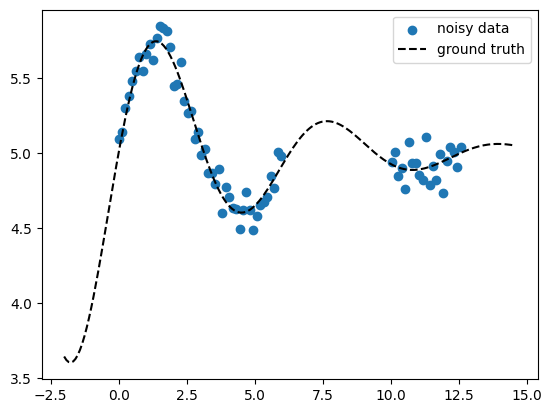

In [11]:
def ground_truth(x, const):
    return torch.sin(x) * torch.exp(-0.2 * x) + const


def generate_data(x, gaps=[[1, 3]], const=None, noise_std=None):
    noise_dist = torch.distributions.Normal(loc=0, scale=noise_std)
    y = ground_truth(x, const=const) + noise_dist.sample(
        sample_shape=(len(x),)
    )
    msk = torch.tensor([True] * len(x))
    if gaps is not None:
        for g in gaps:
            msk = msk & ~((x > g[0]) & (x < g[1]))
    return x[msk], y[msk], y


const = 5.0
noise_std = 0.1
x = torch.linspace(0, 4 * math.pi, 100)
X_train, y_train, y_gt_train = generate_data(
    x, gaps=[[6, 10]], const=const, noise_std=noise_std
)
X_pred = torch.linspace(
    X_train[0] - 2, X_train[-1] + 2, 200, requires_grad=False
)
y_gt_pred = ground_truth(X_pred, const=const)

print(f"{X_train.shape=}")
print(f"{y_train.shape=}")
print(f"{X_pred.shape=}")

fig, ax = plt.subplots()
ax.scatter(X_train, y_train, marker="o", color="tab:blue", label="noisy data")
ax.plot(X_pred, y_gt_pred, ls="--", color="k", label="ground truth")
ax.legend()

# Define GP model

We define the simplest possible textbook GP model using a Gaussian
likelihood. The kernel is the squared exponential kernel with a scaling
factor.

$$\kappa(\ve x_i, \ve x_j) = s\,\exp\left(-\frac{\lVert\ve x_i - \ve x_j\rVert_2^2}{2\,\ell^2}\right)$$

This makes two hyper params, namely the length scale $\ell$ and the scaling
$s$. The latter is implemented by wrapping the `RBFKernel` with
`ScaleKernel`.

In addition, we define a constant mean via `ConstantMean`. Finally we have
the likelihood variance $\sigma_n^2$. So in total we have 4 hyper params.

* $\ell$ = `model.covar_module.base_kernel.lengthscale`
* $\sigma_n^2$ = `model.likelihood.noise_covar.noise`
* $s$ = `model.covar_module.outputscale`
* $m(\ve x) = c$ = `model.mean_module.constant`

In [12]:
class ExactGPModel(gpytorch.models.ExactGP):
    """API:

    model.forward()             prior                   f_pred
    model()                     posterior               f_pred

    likelihood(model.forward()) prior with noise        y_pred
    likelihood(model())         posterior with noise    y_pred
    """

    def __init__(self, X_train, y_train, likelihood):
        super().__init__(X_train, y_train, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel()
        )

    def forward(self, x):
        """The prior, defined in terms of the mean and covariance function."""
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(X_train, y_train, likelihood)

In [13]:
# Inspect the model
print(model)

ExactGPModel(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (mean_module): ConstantMean()
  (covar_module): ScaleKernel(
    (base_kernel): RBFKernel(
      (raw_lengthscale_constraint): Positive()
    )
    (raw_outputscale_constraint): Positive()
  )
)


In [14]:
# Default start hyper params
pprint(extract_model_params(model))

{'covar_module.base_kernel.lengthscale': tensor([[0.6931]], grad_fn=<SoftplusBackward0>),
 'covar_module.outputscale': tensor(0.6931, grad_fn=<SoftplusBackward0>),
 'likelihood.noise_covar.noise': tensor([0.6932], grad_fn=<AddBackward0>),
 'mean_module.constant': Parameter containing:
tensor(0., requires_grad=True)}


In [15]:
# Set new start hyper params
model.mean_module.constant = 3.0
model.covar_module.base_kernel.lengthscale = 1.0
model.covar_module.outputscale = 1.0
model.likelihood.noise_covar.noise = 1e-3

pprint(extract_model_params(model))

{'covar_module.base_kernel.lengthscale': tensor([[1.]], grad_fn=<SoftplusBackward0>),
 'covar_module.outputscale': tensor(1., grad_fn=<SoftplusBackward0>),
 'likelihood.noise_covar.noise': tensor([0.0010], grad_fn=<AddBackward0>),
 'mean_module.constant': Parameter containing:
tensor(3., requires_grad=True)}


# Sample from the GP prior

We sample a number of functions $f_m, m=1,\ldots,M$ from the GP prior and
evaluate them at all $\ma X$ = `X_pred` points, of which we have $N=200$. So
we effectively generate samples from `pri_f` =  $p(\predve f|\ma X) = \mathcal N(\ve
c, \ma K)$. Each sampled vector $\predve f\in\mathbb R^{N}$ represents a
sampled *function* $f$ evaluated the $N=200$ points in $\ma X$. The
covariance (kernel) matrix is $\ma K\in\mathbb R^{N\times N}$. Its diagonal
$\diag\ma K$ = `f_std**2` represents the variance at each point on the $x$-axis.
This is what we plot as "confidence band" `f_mean` $\pm$ `2 * f_std`.
The off-diagonal elements represent the correlation between different points
$K_{ij} = \cov[f(\ve x_i), f(\ve x_j)]$.

/usr/local/lib/python3.11/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


pri_f=MultivariateNormal(loc: torch.Size([200]))
pri_f.mean.shape=torch.Size([200])
pri_f.covariance_matrix.shape=torch.Size([200, 200])
f_samples.shape=torch.Size([10, 200])


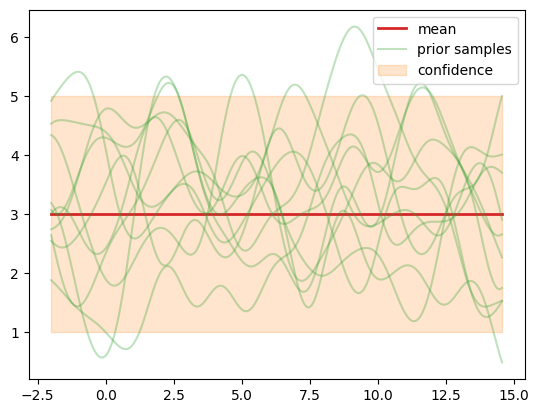

In [16]:
model.eval()
likelihood.eval()

with torch.no_grad():
    # Prior
    M = 10
    pri_f = model.forward(X_pred)
    f_mean = pri_f.mean
    f_std = pri_f.stddev
    f_samples = pri_f.sample(sample_shape=torch.Size((M,)))
    print(f"{pri_f=}")
    print(f"{pri_f.mean.shape=}")
    print(f"{pri_f.covariance_matrix.shape=}")
    print(f"{f_samples.shape=}")
    fig, ax = plt.subplots()
    ax.plot(X_pred, f_mean, color="tab:red", label="mean", lw=2)
    plot_samples(ax, X_pred, f_samples, label="prior samples")
    ax.fill_between(
        X_pred,
        f_mean - 2 * f_std,
        f_mean + 2 * f_std,
        color="tab:orange",
        alpha=0.2,
        label="confidence",
    )
    ax.legend()

Let's investigate the samples more closely. First we note that the samples
fluctuate around the mean `model.mean_module.constant` we defined above. A
constant mean $\ve m(\ma X) = \ve c$ does *not* mean that each sampled vector
$\predve f$'s mean is equal to $c$. Instead, we have that at each $\ve x_i$,
the mean of *all* sampled functions is the same, so $\frac{1}{M}\sum_{j=1}^M
f_m(\ve x_i) \approx c$ and for $M\rightarrow\infty$ it will be exactly $c$.


In [17]:
# Look at the first 20 x points from M=10 samples
print(f"{f_samples.shape=}")
print(f"{f_samples.mean(axis=0)[:20]=}")
print(f"{f_samples.mean(axis=0).mean()=}")
print(f"{f_samples.mean(axis=0).std()=}")

f_samples.shape=torch.Size([10, 200])
f_samples.mean(axis=0)[:20]=tensor([3.2870, 3.2644, 3.2399, 3.2143, 3.1882, 3.1621, 3.1368, 3.1128, 3.0905,
        3.0703, 3.0522, 3.0365, 3.0230, 3.0114, 3.0016, 2.9931, 2.9856, 2.9788,
        2.9723, 2.9658])
f_samples.mean(axis=0).mean()=tensor(3.2061)
f_samples.mean(axis=0).std()=tensor(0.2459)


In [18]:
# Take more samples, the means should get closer to c
f_samples = pri_f.sample(sample_shape=torch.Size((M * 200,)))
print(f"{f_samples.shape=}")
print(f"{f_samples.mean(axis=0)[:20]=}")
print(f"{f_samples.mean(axis=0).mean()=}")
print(f"{f_samples.mean(axis=0).std()=}")

f_samples.shape=torch.Size([2000, 200])
f_samples.mean(axis=0)[:20]=tensor([2.9535, 2.9550, 2.9565, 2.9580, 2.9594, 2.9609, 2.9624, 2.9639, 2.9655,
        2.9672, 2.9691, 2.9711, 2.9733, 2.9756, 2.9782, 2.9810, 2.9840, 2.9872,
        2.9904, 2.9937])
f_samples.mean(axis=0).mean()=tensor(2.9894)
f_samples.mean(axis=0).std()=tensor(0.0158)


# GP posterior predictive distribution with fixed hyper params

Now we calculate the posterior predictive distribution $p(\test{\predve
f}|\test{\ma X}, \ma X, \ve y) = \mathcal N(\test{\ve\mu}, \test{\ma\Sigma})$,
i.e. we condition on the train data (Bayesian
inference).

We use the fixed hyper param values defined above. In particular, since
$\sigma_n^2$ = `model.likelihood.noise_covar.noise` is > 0, we have a
regression setting -- the GP's mean doesn't interpolate all points.

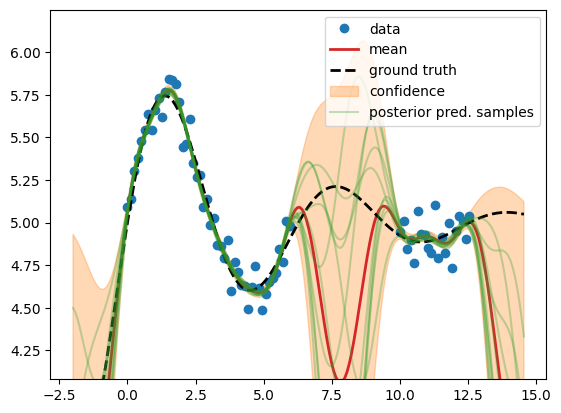

In [19]:
# Evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

with torch.no_grad():
    M = 10
    post_pred_f = model(X_pred)

    fig, ax = plt.subplots()
    f_mean = post_pred_f.mean
    f_samples = post_pred_f.sample(sample_shape=torch.Size((M,)))
    f_std = post_pred_f.stddev
    lower = f_mean - 2 * f_std
    upper = f_mean + 2 * f_std
    ax.plot(
        X_train.numpy(),
        y_train.numpy(),
        "o",
        label="data",
        color="tab:blue",
    )
    ax.plot(
        X_pred.numpy(),
        f_mean.numpy(),
        label="mean",
        color="tab:red",
        lw=2,
    )
    ax.plot(
        X_pred.numpy(),
        y_gt_pred.numpy(),
        label="ground truth",
        color="k",
        lw=2,
        ls="--",
    )
    ax.fill_between(
        X_pred.numpy(),
        lower.numpy(),
        upper.numpy(),
        label="confidence",
        color="tab:orange",
        alpha=0.3,
    )
    y_min = y_train.min()
    y_max = y_train.max()
    y_span = y_max - y_min
    ax.set_ylim([y_min - 0.3 * y_span, y_max + 0.3 * y_span])
    plot_samples(ax, X_pred, f_samples, label="posterior pred. samples")
    ax.legend()

We observe that all sampled functions (green) and the mean (red) tend towards
the low fixed mean function $m(\ve x)=c$ at 3.0 in the absence of data, while
the actual data mean is `const` from above (data generation). Also the other
hyper params ($\ell$, $\sigma_n^2$, $s$) are just guesses. Now we will
calculate their actual value by minimizing the negative log marginal
likelihood.

# Fit GP to data: optimize hyper params

In each step of the optimizer, we condition on the training data (e.g. do
Bayesian inference) to calculate the posterior predictive distribution for
the current values of the hyper params. We iterate until the negative log marginal
likelihood is converged.

We use a simplistic PyTorch-style hand written train loop without convergence
control, so make sure to use enough `n_iter` and eyeball-check that the loss
is converged :-)

In [20]:
# Train mode
model.train()
likelihood.train()

optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
loss_func = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

n_iter = 200
history = defaultdict(list)
for ii in range(n_iter):
    optimizer.zero_grad()
    loss = -loss_func(model(X_train), y_train)
    loss.backward()
    optimizer.step()
    if (ii + 1) % 10 == 0:
        print(f"iter {ii + 1}/{n_iter}, {loss=:.3f}")
    for p_name, p_val in extract_model_params(model, try_item=True).items():
        history[p_name].append(p_val)
    history["loss"].append(loss.item())

iter 10/200, loss=-0.133
iter 20/200, loss=-0.603
iter 30/200, loss=-0.689
iter 40/200, loss=-0.700
iter 50/200, loss=-0.712
iter 60/200, loss=-0.730
iter 70/200, loss=-0.737
iter 80/200, loss=-0.738
iter 90/200, loss=-0.739
iter 100/200, loss=-0.739
iter 110/200, loss=-0.739
iter 120/200, loss=-0.739
iter 130/200, loss=-0.739
iter 140/200, loss=-0.739
iter 150/200, loss=-0.739
iter 160/200, loss=-0.739
iter 170/200, loss=-0.739
iter 180/200, loss=-0.739
iter 190/200, loss=-0.739
iter 200/200, loss=-0.739


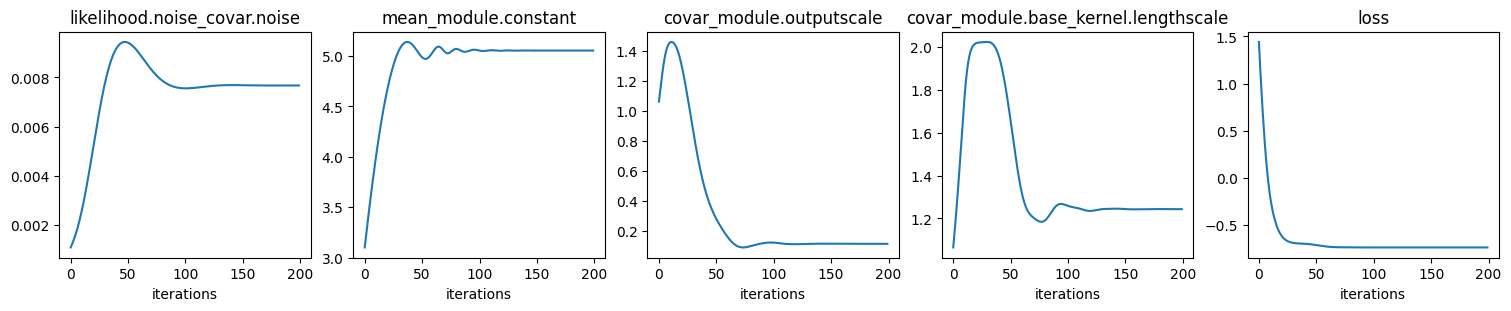

In [21]:
# Plot hyper params and loss (negative log marginal likelihood) convergence
ncols = len(history)
fig, axs = plt.subplots(
    ncols=ncols, nrows=1, figsize=(ncols * 3, 3), layout="compressed"
)
with torch.no_grad():
    for ax, (p_name, p_lst) in zip(axs, history.items()):
        ax.plot(p_lst)
        ax.set_title(p_name)
        ax.set_xlabel("iterations")

In [22]:
# Values of optimized hyper params
pprint(extract_model_params(model))

{'covar_module.base_kernel.lengthscale': tensor([[1.2430]], grad_fn=<SoftplusBackward0>),
 'covar_module.outputscale': tensor(0.1167, grad_fn=<SoftplusBackward0>),
 'likelihood.noise_covar.noise': tensor([0.0077], grad_fn=<AddBackward0>),
 'mean_module.constant': Parameter containing:
tensor(5.0548, requires_grad=True)}


We see that all hyper params converge. In particular, note that the constant
mean $m(\ve x)=c$ converges to the `const` value in `generate_data()`.

# Run prediction

We run prediction with two variants of the posterior predictive distribution:
using either only the epistemic uncertainty or using the total uncertainty.

* epistemic: $p(\test{\predve f}|\test{\ma X}, \ma X, \ve y) =
  \mathcal N(\test{\ve\mu}, \test{\ma\Sigma})$ = `post_pred_f` with
  $\test{\ma\Sigma} = \testtest{\ma K} - \test{\ma K}\,(\ma K+\sigma_n^2\,\ma I)^{-1}\,\test{\ma K}^\top$
* total: $p(\test{\predve y}|\test{\ma X}, \ma X, \ve y) =
  \mathcal N(\test{\ve\mu}, \test{\ma\Sigma} + \sigma_n^2\,\ma I_N))$ = `post_pred_y`

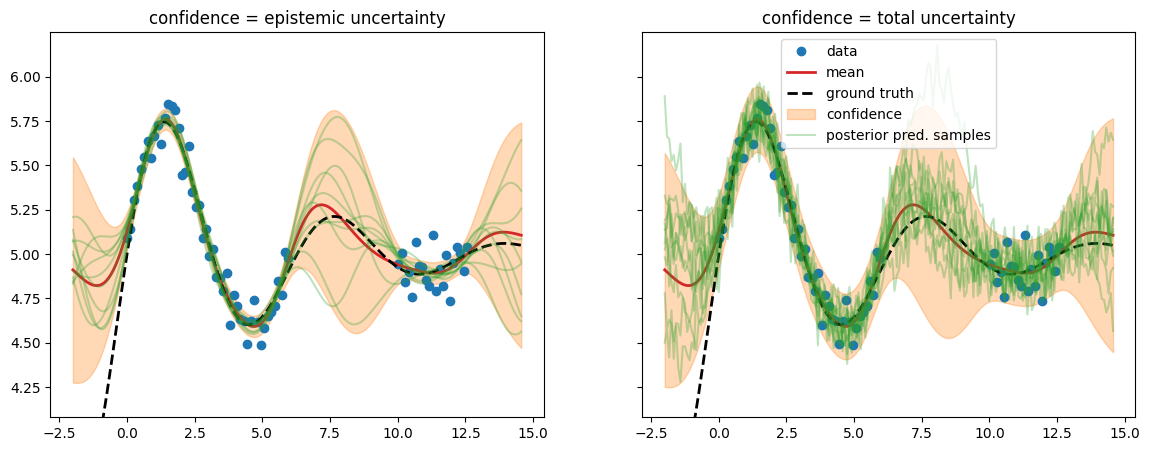

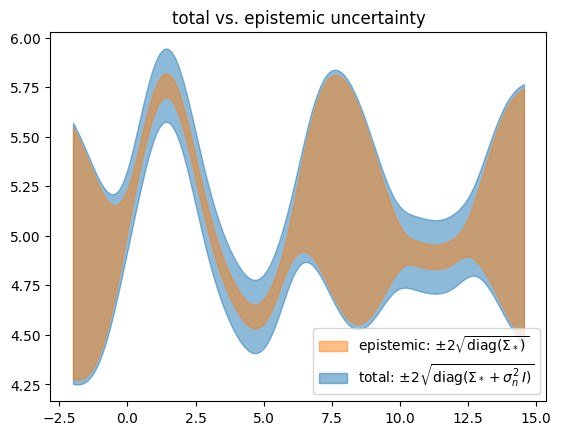

In [23]:
# Evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

with torch.no_grad():
    M = 10
    post_pred_f = model(X_pred)
    post_pred_y = likelihood(model(X_pred))

    fig, axs = plt.subplots(ncols=2, figsize=(14, 5), sharex=True, sharey=True)
    fig_sigmas, ax_sigmas = plt.subplots()
    for ii, (ax, post_pred, name, title) in enumerate(
        zip(
            axs,
            [post_pred_f, post_pred_y],
            ["f", "y"],
            ["epistemic uncertainty", "total uncertainty"],
        )
    ):
        yf_mean = post_pred.mean
        yf_samples = post_pred.sample(sample_shape=torch.Size((M,)))

        yf_std = post_pred.stddev
        lower = yf_mean - 2 * yf_std
        upper = yf_mean + 2 * yf_std
        ax.plot(
            X_train.numpy(),
            y_train.numpy(),
            "o",
            label="data",
            color="tab:blue",
        )
        ax.plot(
            X_pred.numpy(),
            yf_mean.numpy(),
            label="mean",
            color="tab:red",
            lw=2,
        )
        ax.plot(
            X_pred.numpy(),
            y_gt_pred.numpy(),
            label="ground truth",
            color="k",
            lw=2,
            ls="--",
        )
        ax.fill_between(
            X_pred.numpy(),
            lower.numpy(),
            upper.numpy(),
            label="confidence",
            color="tab:orange",
            alpha=0.3,
        )
        ax.set_title(f"confidence = {title}")
        if name == "f":
            sigma_label = r"epistemic: $\pm 2\sqrt{\mathrm{diag}(\Sigma_*)}$"
            zorder = 1
        else:
            sigma_label = (
                r"total: $\pm 2\sqrt{\mathrm{diag}(\Sigma_* + \sigma_n^2\,I)}$"
            )
            zorder = 0
        ax_sigmas.fill_between(
            X_pred.numpy(),
            lower.numpy(),
            upper.numpy(),
            label=sigma_label,
            color="tab:orange" if name == "f" else "tab:blue",
            alpha=0.5,
            zorder=zorder,
        )
        y_min = y_train.min()
        y_max = y_train.max()
        y_span = y_max - y_min
        ax.set_ylim([y_min - 0.3 * y_span, y_max + 0.3 * y_span])
        plot_samples(ax, X_pred, yf_samples, label="posterior pred. samples")
        if ii == 1:
            ax.legend()
    ax_sigmas.set_title("total vs. epistemic uncertainty")
    ax_sigmas.legend()

We find that $\test{\ma\Sigma}$ reflects behavior we would like to see from
epistemic uncertainty -- it is high when we have no data
(out-of-distribution). But this alone isn't the whole story. We need to add
the estimated likelihood variance $\sigma_n^2$ in order for the confidence
band to cover the data -- this turns the estimated total uncertainty into a
*calibrated* uncertainty.

# Let's check the learned noise

We compare the target data noise (`noise_std`) to the learned GP noise, in
the form of the likelihood *standard deviation* $\sigma_n$. The latter is
equal to the $\sqrt{\cdot}$ of `likelihood.noise_covar.noise` and can also be
calculated via $\sqrt{\diag(\test{\ma\Sigma} + \sigma_n^2\,\ma I_N) -
\diag(\test{\ma\Sigma}})$.

In [24]:
# Target noise to learn
print("data noise:", noise_std)

# The two below must be the same
print(
    "learned noise:",
    (post_pred_y.stddev**2 - post_pred_f.stddev**2).mean().sqrt().item(),
)
print(
    "learned noise:",
    np.sqrt(
        extract_model_params(model, try_item=True)[
            "likelihood.noise_covar.noise"
        ]
    ),
)

data noise: 0.1
learned noise: 0.08758186260974431
learned noise: 0.08758186260974431


In [25]:
# When running as script
if not is_interactive():
    plt.show()